# 1. Sequence Retrieval, Consensus Tree and newick-iTOL visualisation: Assessing the Role of Microbial Genera in Corrosion Failure of Water and Cooling Systems

## 1.1. Introduction 
This notebook follows the next steps of the previous notebook 4. The main objective is to sequence, make a newick tree hierarchical tree for each of the tree base dataframes 
Core taxa tree (~60 highest abundance bacteria)
Usual suspects tree (known corrosion-causing bacteria)
Checked genera tree (statistically significant bacteria)
Then making the sequence of the merged three dataframes core_check_usual_taxa.
This notebook builds upon findings from notebook 4, focusing on the phylogenetic analysis of bacterial genera associated with corrosion in water and cooling systems. Through the systematic retrieval and analysis of 16S rRNA sequences from the NCBI GenBank database, we aim to construct phylogenetic trees for three distinct bacterial groups: the core taxa representing the 60 most abundant bacteria, the usual suspects comprising known corrosion-causing bacteria, and the checked genera identified through statistical significance.
The analysis begins with individual tree construction for each group, followed by the creation of a merged phylogenetic tree incorporating all three datasets. This approach serves multiple purposes: it validates our statistical findings against known corrosion-causers, reveals evolutionary relationships that might explain shared mechanisms, and provides context for newly identified bacteria. By implementing UPGMA methodology and bootstrap analysis, we ensure robust tree construction and reliability assessment.
Our workflow encompasses sequence retrieval from NCBI, data validation, sequence alignment, and consensus tree construction. The resulting phylogenetic relationships will illuminate community power dynamics and bacterial assembly patterns, establishing a foundation for subsequent metabolic pathway analysis through PICRUSt. This understanding is crucial for the final machine learning ensemble, where we will integrate these findings with physicochemical data from Repository 1_Physicochemical.
The notebook employs various safety measures and optimization techniques, including controlled server interaction and comprehensive error handling, ensuring reliable data collection and analysis. Through this systematic approach, we aim to deepen our understanding of microbially influenced corrosion while establishing a robust framework for future analyses.

I am having problems installilng packages from the terminal, so I am installing the biophyton from here.

## 1.2 Preprocessing the data 
This notebook has been worked in colab and in vsc, the code is silence eitherway.
### Mounting the data in colab

In [1]:
'''from google.colab import drive  #silence for vscode
drive.mount('/content/drive')

#change the path
os.chdir('/content/drive/My Drive/MIC')'''

'''%pip install dendropy
%pip install --upgrade pip
# for colab and in the terminal 
#!pip install biopython'''
'''
from Bio import Phylo
import matplotlib.pyplot as plt
plt.figure(figsize=(15, 10))  # Adjust size as needed
Phylo.draw(consensus_tree)
plt.show()
'''

'%pip install dendropy\n%pip install --upgrade pip'

### 1.3. Importing the necesary libraries

In [1]:
# Create organized folder structure
from pathlib import Path
import time
import pandas as pd
import numpy as np
from Bio import Phylo
import matplotlib.pyplot as plt
import os
from Bio import Entrez, SeqIO, AlignIO
import subprocess
from Bio.Seq import Seq
from Bio.SeqRecord import SeqRecord
from Bio.Phylo.TreeConstruction import DistanceCalculator, DistanceTreeConstructor
#from Bio.Phylo import draw
from random import choice
from Bio.Align import MultipleSeqAlignment
from Bio.Phylo.Consensus import majority_consensus
from typing import Dict, List, Optional
from datetime import datetime
import logging
from dataclasses import dataclass
# Load and prepare the tree
from ete3 import Tree, TreeStyle, NodeStyle, TextFace, RectFace, faces, CircleFace
from math import log
import json
import dendropy 
from dendropy import Tree
import tempfile
from IPython.display import display, Image # Display image inline

## 1.4. Creating a Folder for the Results: Data_tree
dedicated folder to keep the results and bootstraping of the present notebook  

In [54]:
# For VSCode
base_dir = Path("/home/beatriz/MIC/2_Micro/data_qiime
bootstrap_dir = base_dir / "bootstrapping"
bootstrap_dir.mkdir(exist_ok=True)

# For Colab
'''
from google.colab import drive
drive.mount('/content/drive')
base_dir = Path('/content/drive/My Drive/MIC/data')
bootstrap_dir = base_dir / "bootstrapping"
bootstrap_dir.mkdir(exist_ok=True)
'''

'\nfrom google.colab import drive\ndrive.mount(\'/content/drive\')\nbase_dir = Path(\'/content/drive/My Drive/MIC/data\')\nbootstrap_dir = base_dir / "bootstrapping"\nbootstrap_dir.mkdir(exist_ok=True)\n'

## 1.5. Loadging, cleaning and preparing the dataframe
This notebook is made specially to run one individual dataframe coming from : core_taxa and checked_genera come from book 3 directory /data. Usual genera was built on notebook 3 but has been re-think on notebook 4. The merged dataframe core_check_usual_taxa was built from the merge of all three trees and was built also on notebook 4. 
For simplicity the notebook is aim to run only one of this individual files only to change the origin import in excel and the color scheme in the iTOL section, which is done by silence and select the source_type in the next cell. 

In [55]:
#loading only one of each of the three dataframes for every complete run of the notebook
#source_type = 'checked'  # genera come from book 3 directly directory /data
#source_type = 'usual' #  re-made come from book 4 directory /data_ref
#source_type = 'core'   # genera come from book 3 directly directory /data
source_type = 'check_core_usual' # made on book 4 directory /data_ref

In [56]:
# Read the Excel file
#selected = pd.read_excel("data/finalist_dfs.xlsx", sheet_name='core_taxa', header=[0,1,2,3,4,5,6,7])
selected = pd.read_excel('~/MIC/2_Micro/data_Ref/merged_to_sequence.xlsx', sheet_name='core_check_usual_taxa', header=[0,1,2,3,4,5,6,7])

# Drop first row specifically (index 0 which contains NaNs)
selected = selected.drop(index=0)
# Drop first column (the index column with Level1, Level2, etc)
selected = selected.drop(selected.columns[0], axis=1)
# Remove 'Unnamed' level names
selected.columns = selected.columns.map(lambda x: tuple('' if 'Unnamed' in str(level) else level for level in x))

In [57]:
# If the dataframe has Nan in sites it will replace it with Source
selected['Sites'] = selected['Sites'].fillna('Source')
# Fill the other index with nothing
selected = selected.fillna(' ')
# Setting index to Sites
selected= selected.set_index("Sites")
selected_taxa = selected.T
selected_taxa  = selected_taxa.reset_index()

In [58]:
selected_taxa.head()

Sites                                           level_0   level_1  \
0                                              Category             
1                 Rhodocyclales_Rhodocyclaceae_Azospira  Bacteria   
2      Actinomycetales_Dermabacteraceae_Brachybacterium  Bacteria   
3      Actinomycetales_Brevibacteriaceae_Brevibacterium  Bacteria   
4      Erysipelotrichales_Erysipelotrichaceae_Bulleidia  Bacteria   

Sites         level_2             level_3             level_4  \
0                                                               
1      Proteobacteria  Betaproteobacteria       Rhodocyclales   
2      Actinobacteria      Actinobacteria     Actinomycetales   
3      Actinobacteria      Actinobacteria     Actinomycetales   
4          Firmicutes     Erysipelotrichi  Erysipelotrichales   

Sites              level_5          level_6 level_7     site_1   site_2  ...  \
0                                                          3.0      1.0  ...   
1           Rhodocyclaceae         Azospira     110  26.928048  1.85923  ...   
2         Dermabacteraceae  Brachybacterium     140          0        0  ...   
3        Brevibacteriaceae   Brevibacterium     145          0        0  ...   
4      Erysipelotrichaceae        Bulleidia     154          0        0  ...   

Sites   site_62   site_63 site_64   site_65 site_66   site_67   site_68  \
0           2.0       2.0     2.0       2.0     2.0       3.0       3.0   
1      0.571304  0.624133    0.26  4.518236     0.4  0.004886         0   
2             0         0       0  0.054437       0         0  0.021172   
3             0         0       0  0.217746       0         0         0   
4             0         0       0         0       0         0         0   

Sites site_69 site_70    Source  
0         1.0     1.0            
1        1.47    1.72  chk-core  
2           0       0       chk  
3           0       0       chk  
4           0       0       chk  

[5 rows x 79 columns]

In [68]:
selected_taxa["Source"].unique()

array([' ', 'chk-core', 'chk', 'chk-core-us', 'chk-us', 'core-us', 'core',
       'us'], dtype=object)

# 2. Sequences Retrieval
## 2.1 NBCI communication setup

In [10]:
# Comunicating with the NCBI
from config import NCBI_API_KEY, NCBI_EMAIL
Entrez.email = NCBI_EMAIL
Entrez.api_key = NCBI_API_KEY

In [11]:
def setup_logging():
    """Configure logging to both file and console"""
    logging.basicConfig(
        level=logging.INFO,
        format='%(asctime)s - %(levelname)s - %(message)s',
        handlers=[
            logging.FileHandler('sequence_retrieval.log'),
            logging.StreamHandler()
        ]
    )

## 2.2. Sequence Collection

In [6]:
# Extract Genera from the multi-index and filter out empty strings
genera = [genus for genus in selected.columns.get_level_values(6).to_list() if genus.strip()]

## 2.3. Retriving Data from the NCBI
Following code is silent, so that I dont run it again by mistake and ask again the accession numbers to the NCBI

In [13]:
# Dictionary to store the results
results = {}
def search_sequences(
    genus: str,
    entrez: object,
    max_retries: int = 5,
    base_delay: int = 30,
    max_delay: int = 120
) -> Optional[List[str]]:
    """
    Search for sequences with improved error handling and validation.
    
    Args:
        genus: The genus name to search for
        entrez: Entrez object with configured email and API key
        max_retries: Maximum number of retry attempts
        base_delay: Initial delay between retries in seconds
        max_delay: Maximum delay between retries in seconds
    
    Returns:
        List of sequence IDs or None if unsuccessful
    """
    if not isinstance(genus, str) or not genus.strip():
        raise ValueError("Genus must be a non-empty string")
    if not hasattr(entrez, 'email') or not entrez.email:
        raise RuntimeError("Entrez email configuration missing")
    
    retry_count = 0
    delay = base_delay

    while retry_count < max_retries:
        try:
            search_term = (f"{genus}[Organism] AND " "(16S[All Fields] OR 16S ribosomal RNA[All Fields] OR "
                "16S rRNA[All Fields]) AND " "500:2000[Sequence Length]")
            
            logging.info(f"Attempting search for {genus} (attempt {retry_count + 1}/{max_retries})")
            # Search NCBI database
            handle = entrez.esearch(db="nucleotide", term=search_term, retmax=100)
            
            try:
                record = entrez.read(handle)
                # Add extra delay after successful read
                time.sleep(5)

            except entrez.Parser.ValidationError as ve:
                logging.error(f"NCBI validation error for {genus}: {str(ve)}")
                retry_count += 1
                continue
            finally:
                handle.close()
            
            sequence_count = len(record.get('IdList', []))
            logging.info(f"Found {sequence_count} sequences for {genus}")
                        
            if sequence_count > 0:
                return record['IdList']
            
            logging.warning(f"No sequences found for {genus}")
            return[]
            
        except entrez.HTTPError as he:
            logging.error(f"NCBI HTTP error: {str(he)}")
        except entrez.URLError as ue:
            logging.error(f"NCBI connection error: {str(ue)}")
        except Exception as e:
            logging.error(f"Unexpected error: {str(e)}")

        retry_count += 1
        if retry_count < max_retries:
            wait_time = min(delay * (2 ** retry_count), max_delay)
            logging.info(f"Waiting {wait_time} seconds before retry...")
            time.sleep(wait_time)

            if retry_count >=max_retries:
                logging.error(f"Max retries ({max_retries}) reached for {genus}")
                return None
        return []
# Save progress after each genus
def retrieve_sequences(
    genera: List[str],
    entrez: object,
    output_file: str = "sequence_results.txt",
    progress_file: str = "retrieval_progress.json"
) -> Dict[str, List[str]]:
    """
    Retrieve sequences with comprehensive logging, error handling with progress saving
    
    Args:
        genera: List of genus names
        entrez: Configured Entrez object
        output_file: Path to save detailed results
    
    Returns:
        Dictionary mapping genera to their sequence IDs
    """
    setup_logging()
    logging.info(f"Starting sequence retrieval for {len(genera)} genera")
    
    # Load any existing progress
    results = {}
    if os.path.exists(progress_file):
        try:
            with open(progress_file, 'r') as f:
                content = f.read()
                if content.strip():  # Check if file is not empty
                    results = json.loads(content)
                    logging.info(f"Loaded {len(results)} existing results")
                else:
                    logging.info("Progress file exists but is empty")
        except json.JSONDecodeError:
            logging.warning("Could not decode progress file, starting fresh")
    
    missing_genera = []
    start_time = datetime.now()
    
    total_genera = len(genera)
    processed_count = len(results)

    for genus in genera:
        # Skip if already processed
        if genus in results:
            logging.info(f"Skipping {genus} - already processed")
            continue

        processed_count += 1
        logging.info(f"Processing {genus} ({processed_count}/{total_genera})")
        
        sequence_ids = search_sequences(genus, entrez)
        
        if sequence_ids:
            results[genus] = sequence_ids
            # Save progress after each successful retrieval
            with open(progress_file, 'w') as f:
                json.dump(results, f)
        else:
            missing_genera.append(genus)
        
        success_rate = (len(results) / processed_count) * 100
        logging.info(f"Current success rate: {success_rate:.1f}%")
        
        time.sleep(30)
    
    # Generate summary
    elapsed_time = datetime.now() - start_time
    summary = f"""
    Sequence Retrieval Summary
    -------------------------
    Total genera processed: {total_genera}
    Successful retrievals: {len(results)}
    Failed retrievals: {len(missing_genera)}
    Success rate: {(len(results)/total_genera)*100:.1f}%
    Total time elapsed: {elapsed_time}

    Successful Genera:
    {'-' * 20}
    """ + '\n'.join(f"- {genus}: {len(ids)} sequences" for genus, ids in results.items()) + f"""

    Missing Genera:
    {'-' * 20}
    """ + '\n'.join(f"- {genus}" for genus in missing_genera)
    
    # Save summary to file
    with open(output_file, 'w') as f:
        f.write(summary)
    
    return results

In [14]:
# Calling the function
results = retrieve_sequences(genera, Entrez)

2025-01-16 02:19:12,790 - INFO - Starting sequence retrieval for 84 genera
2025-01-16 02:19:12,834 - INFO - Loaded 60 existing results
2025-01-16 02:19:12,855 - INFO - Skipping Azospira - already processed
2025-01-16 02:19:12,858 - INFO - Processing Brachybacterium (61/84)
2025-01-16 02:19:12,861 - INFO - Attempting search for Brachybacterium (attempt 1/5)
2025-01-16 02:19:20,165 - INFO - Found 100 sequences for Brachybacterium
2025-01-16 02:19:20,242 - INFO - Current success rate: 100.0%
2025-01-16 02:19:50,761 - INFO - Processing Brevibacterium (62/84)
2025-01-16 02:19:50,782 - INFO - Attempting search for Brevibacterium (attempt 1/5)
2025-01-16 02:19:57,505 - INFO - Found 100 sequences for Brevibacterium
2025-01-16 02:19:57,581 - INFO - Current success rate: 100.0%
2025-01-16 02:20:28,076 - INFO - Processing Bulleidia (63/84)
2025-01-16 02:20:28,081 - INFO - Attempting search for Bulleidia (attempt 1/5)
2025-01-16 02:20:34,784 - INFO - Found 97 sequences for Bulleidia
2025-01-16 02:

## 2.4 Sucess Rate Sequenced Genera

In [15]:
print(f"Initial number of genera: {len(genera)}")
print(f"Number of genera with sequences: {len(results)}")
print(f"Success rate: {(len(results)/len(genera)*100):.2f}%")

# If you want to see which genera got sequences:
print("\nGenera with sequences:")
for genus, seq_list in results.items():
    print(f"{genus}: {len(seq_list)} sequences")

Initial number of genera: 84
Number of genera with sequences: 79
Success rate: 94.05%

Genera with sequences:
Acetobacterium: 100 sequences
Bacillus: 100 sequences
Clostridium: 100 sequences
Corynebacterium: 100 sequences
Desulfobacterium: 62 sequences
Desulfobulbus: 100 sequences
Desulfotomaculum: 100 sequences
Desulfovibrio: 100 sequences
Gallionella: 100 sequences
Micrococcus: 100 sequences
Novosphingobium: 100 sequences
Propionibacterium: 100 sequences
Pseudomonas: 100 sequences
Shewanella: 100 sequences
Staphylococcus: 100 sequences
Streptococcus: 100 sequences
Thiobacillus: 100 sequences
Achromobacter: 100 sequences
Acidisoma: 100 sequences
Acidovorax: 100 sequences
Aestuariimicrobium: 33 sequences
Afipia: 100 sequences
Anoxybacillus: 100 sequences
Azospira: 100 sequences
Beta_proteobacterium: 100 sequences
Blastomonas: 100 sequences
Bradyrhizobium: 100 sequences
Brevundimonas: 100 sequences
Candidatus_desulforudis: 2 sequences
Caulobacter: 100 sequences
Chryseobacterium: 100 seq

## 2.5. Resulting accension numbers

In [16]:
# Print the results
for genus, ids in results.items():
    print(f"{genus}: {ids}")

Acetobacterium: ['2644316106', '2815566502', '2798788146', '2798788124', '2798788110', '2798788105', '2559564274', '2559564218', '2559564180', '2559564168', '2559564165', '2559564156', '2559564129', '2559564107', '2559564103', '2559564098', '2559564086', '2559564083', '2556088481', '2556088479', '2556088478', '2556088475', '2556088474', '2556088473', '2556088472', '2556088471', '2556088469', '2556088468', '2556088467', '2556088466', '2556088465', '1896951739', '1896951737', '1896951736', '1896951735', '1896951734', '1896951733', '1896951732', '1896951731', '1896951730', '1896951729', '1896951728', '2524803499', '2524803477', '1731363050', '1731363049', '1731363048', '1731363047', '1731363045', '1731363044', '1731363042', '1731363041', '1731363040', '1731362982', '1731362981', '1731362980', '1731362978', '1731362976', '1731362975', '1731362974', '1731362973', '1731362972', '1731362971', '1731362970', '1731362969', '1731362968', '1731362967', '1731362965', '1731362964', '1084284231', '10

In [17]:
# Create a DataFrame from the dictionary
df_accension = pd.DataFrame(list(results.items()), columns=['Genus', 'IDs'])
df_accension.head(31)

Genus                                                IDs
0            Acetobacterium  [2644316106, 2815566502, 2798788146, 279878812...
1                  Bacillus  [2874247066, 2874247065, 2874247064, 287424706...
2               Clostridium  [2644094938, 2644094937, 2644094936, 264409493...
3           Corynebacterium  [2875870155, 2875870153, 2875870152, 287587015...
4          Desulfobacterium  [2041342285, 2041342277, 1881041610, 188071607...
5             Desulfobulbus  [1994283362, 1994283361, 1994283358, 199428335...
6          Desulfotomaculum  [1468629952, 1468629948, 1468629946, 146862994...
7             Desulfovibrio  [2644309640, 2679265074, 2679264916, 267925432...
8               Gallionella  [2737473153, 2558431767, 2257533251, 225753325...
9               Micrococcus  [2874253589, 2642193425, 2640237036, 263983822...
10          Novosphingobium  [2873344260, 2590515287, 2508041327, 250804132...
11        Propionibacterium  [2815386905, 2519610465, 2519588122, 230366688...
12              Pseudomonas  [2876039251, 2876031393, 2874270691, 287424764...
13               Shewanella  [2874247159, 2623593643, 2623593639, 262359363...
14           Staphylococcus  [2876031387, 2876031372, 2874270805, 264466082...
15            Streptococcus  [2874254925, 2130558661, 2130558657, 213055865...
16             Thiobacillus  [2868819141, 2172332960, 2784215697, 254069259...
17            Achromobacter  [2874270692, 2874246232, 2874235207, 287423520...
18                Acidisoma  [2125541608, 2125541607, 2125541606, 212554160...
19               Acidovorax  [2747349660, 2874160785, 2874160781, 287416077...
20       Aestuariimicrobium  [1985942822, 1985942820, 1985942819, 230259673...
21                   Afipia  [736448047, 2810195243, 2793107742, 2787284317...
22            Anoxybacillus  [1918129051, 1918127337, 1918126095, 191812474...
23                 Azospira  [2815233668, 2815233665, 2815233662, 281523365...
24     Beta_proteobacterium  [2557661211, 2557661190, 2557661166, 255766115...
25              Blastomonas  [2798793774, 2798793771, 2798793766, 279879376...
26           Bradyrhizobium  [2592495114, 2592495113, 2592495086, 259249381...
27            Brevundimonas  [2129792118, 2129792109, 2873256855, 287415640...
28  Candidatus_desulforudis                             [387175155, 283443553]
29              Caulobacter  [2747349674, 2871849568, 2871837899, 286881231...
30         Chryseobacterium  [2874246377, 2689241335, 2747349681, 274734967...

## 2.6 Combining the Taxa with the Abundance Values in a Dataframe 

In [7]:
current_columns = selected_taxa.columns.tolist()
new_columns = ['Jointax', 'Kingdom','Phylum', 'Class', 'Order', 'Family', 'Genus', 'GID']
combined_columns= new_columns + current_columns[8:]
selected_taxa.columns = combined_columns

## 2.7. Merging Taxa, Abundance and Accension Numbers on a dataframe

In [20]:
# Merge the two DataFrames on the 'Genus' column
taxa_accension = pd.merge(selected_taxa, df_accension, on='Genus')

In [21]:
# Save the merged sequences to use making the dendrogram notebook
taxa_accension.to_csv('data_tree/taxa_accension.csv', index=False)

# 3. Retrieving Sequencies with the Accession Numbers
These numbers are the GenBank accession numbers, which are unique identifiers for sequences in the GenBank database. Following is to retrieve the actual sequences using these accession numbers.
## 3.1. Define get_sequence function: Final Sequences

In [22]:
# Specify email (required by NCBI)
Entrez.email = "wattsbeatrizamanda@gmail.com"

# Retrieve the sequence for a given accession number
def get_sequence(accession):
    try:
       handle = Entrez.efetch(db="nucleotide", 
                             id=accession, 
                             rettype="fasta",  # Keep FASTA format
                             retmode="text")
       record = SeqIO.read(handle, "fasta")
       handle.close()
        
       sequence = str(record.seq)
       if sequence and len(sequence) > 0:  # Check if sequence exists and is not empty
           print(f"Got sequence of length {len(sequence)} for {accession}")
           return sequence
       else:
           print(f"Warning: Empty sequence for {accession}")
           return None
        
    except Exception as e:
        print(f"Failed to get sequence for {accession}: {e}")
        return None

Make the df with the accension numbers with the actual number and not just the index, code difficult to run in this machine

## 3.2 Validation the Retrieved Sequences

In [23]:
def validate_sequence(sequence):
    """Basic sequence validation"""
    return len(sequence) >= 500  # check if sequence is long enough

results =[]
# Loop over the rows in the DataFrame
for i, row in taxa_accension.iterrows():
    # Get the genus, GID and accession numbers for the current row
    genus = row['Genus']
    gid = row['GID']
    
    # Convert string representation of list to actual list 
    accession_numbers = row['IDs']

    # Debug - print current genus being processed
    print(f"Processing {genus}")

    # Initialize a variable to store the accession number that returns a valid sequence
    valid_accession = None

    # Loop over the accession numbers
    for accession in accession_numbers:
        # Retrieve the sequence
        sequence = get_sequence(accession)

        # Debug print
        if sequence:
            print(f"Sequence length: {len(sequence)}")

        # Check if a sequence was found and is valid
        if sequence is not None and validate_sequence(sequence):
            # Store the accession number and sequence
            valid_accession = accession
            valid_sequence = sequence
            break
    
    # If we found a valid sequence, add it to results
    if valid_accession is not None:
        results.append({
            'Genus': genus,
            'GID': gid,
            'Accession': valid_accession,
            'Sequence': valid_sequence
        })

    # Pause for 5 second
    time.sleep(5)

# Convert the list of results to a DataFrame
final_sequences = pd.DataFrame(results)

# Print some information about the results
print(f"\nNumber of sequences retrieved: {len(final_sequences)}")
print("\nFirst few rows:")
print(final_sequences.head(31))

Processing Azospira
Got sequence of length 1057 for 2815233668
Sequence length: 1057
Processing Brachybacterium
Got sequence of length 1385 for 2159029981
Sequence length: 1385
Processing Brevibacterium
Got sequence of length 1366 for 2874253588
Sequence length: 1366
Processing Bulleidia
Got sequence of length 1617 for 283769288
Sequence length: 1617
Processing Clostridium
Got sequence of length 601 for 2644094938
Sequence length: 601
Processing Corynebacterium
Got sequence of length 542 for 2875870155
Sequence length: 542
Processing Enterococcus
Failed to get sequence for 2876031399: No records found in handle
Failed to get sequence for 2876031397: No records found in handle
Got sequence of length 1464 for 2874246379
Sequence length: 1464
Processing Gelria
Got sequence of length 1710 for 1942498386
Sequence length: 1710
Processing Halomonas
Got sequence of length 1410 for 2624778934
Sequence length: 1410
Processing Legionella
Got sequence of length 560 for 2874356540
Sequence length: 

In [24]:
# Print the first few rows of the DataFrame
final_sequences.head(2)

Genus  GID   Accession  \
0             Azospira  110  2815233668   
1      Brachybacterium  140  2159029981   
2       Brevibacterium  145  2874253588   
3            Bulleidia  154   283769288   
4          Clostridium  214  2644094938   
5      Corynebacterium  229  2875870155   
6         Enterococcus  300  2874246379   
7               Gelria  334  1942498386   
8            Halomonas  354  2624778934   
9           Legionella  408  2874356540   
10       Mycobacterium  470  2339752245   
11           Mycoplana  471  2815432690   
12           Neisseria  474   545068913   
13     Novosphingobium  491  2873344260   
14           Oerskovia  497  2815921019   
15            Opitutus  503  1381958996   
16           Oxobacter  512   939330616   
17          Paracoccus  526  2874143706   
18    Phenylobacterium  549  2873827928   
19      Porphyrobacter  564  2868819039   
20          Prevotella  566  2796461632   
21   Pseudarthrobacter  583  2874350428   
22   Pseudoalteromonas  584  2863932830   
23       Streptococcus  687  2874254925   
24         Tepidimonas  712  2873960584   
25        Thiobacillus  727  2868819141   
26      Acetobacterium    6  2644316106   
27       Achromobacter    7  2874270692   
28           Acidisoma   13  2125541608   
29          Acidovorax   17  2747349660   
30  Aestuariimicrobium   29  1985942822   

                                             Sequence  
0   GACCTTCTTCCATGGCGATCGGGGCGATCAGCTTGACGGTCATGCT...  
1   TACCATGCAGTCGACGATGACGACCGAGCTTGCTCGGTCTGATTAG...  
2   CCTGGTGCTTGCACCGGGGTGGATGAGTGGCGAACGGGTGAGTAAC...  
3   TTCTCTCATTTTCTTCGATTTTATCATCAATAGAGCCAAGCATAGA...  
4   TCTTTACACATTTCGTGAACTGTGTCGTGGATTGCATCTAAGTTTA...  
5   AGTTTCCATAATCCGGGGGGTGTTGCCGCCGGGTGCCAGGACTTTC...  
6   CGGCGGCGGCTGCCTAATACTGCAAGTCGAACGCTTCTTTTCACCG...  
7   GACGAACGCTGGCGGCGCGCCTAACACATGCAAGTCGAACGTGTTA...  
8   TGCAAGTCGAGCGGCAGCACGGGAAGCTTGCTTCCTGGTGGCGAGC...  
9   ATGGCGAAGGAAAAATTTGAACGTAAGAAGCCGCACGTAAACGTGG...  
10  CCGCCGACGAAGGTGGTGGCCATCAACTCGGGTTCGCCGGCCAGTT...  
11  TGACCTGCCACTGAGAATTTCCTCCAGAATGGATTAGAGTCCGGCC...  
12  CGCGCAGGCGGGAATCTAGAAATGAAAAACCACGGTGTTATCGGAA...  
13  AACGAACGCTGGCGGCATGCCTAACACATGCAAGTCGAACGAAGCC...  
14  CTTGTGCGACACGCCCGGCGTGTCGCACAAGAGCTCCGCACTCAGC...  
15  CCGAAACGATGCGGTTGAAAGGGAGCCACCGTCTGAGAAGTGATTG...  
16  CTCTTACTTCTGAAAGCCTGTTTGCAAGATCGTAAACATACCTATA...  
17  ACCACCGAAACCTGGCACGCGTTCCTCGACGACTTTGTCGATGACG...  
18  CCGACCGGGCGGTGAAGGTCATCACGGCCACCGAGGCGGGCGAACT...  
19  CATGGCGGCTGCCTACACATGCAGTCGAACGAGACCTTCGGGTCTA...  
20  AAGAGCATGGTGGAGATAGCCAGTGATGTGGTGGTAGGAAAAGACA...  
21  GGGGCTTTGCGGCCGAGCCTTACACATGCAGTCGAACGATGAAGCC...  
22  GCCTGATGCAGCCATGCCGCGTGTGTGAAGAAGGCCTTCGGGTTGT...  
23  AGAGTTTGATCCTGGCTCAGGACGAACGCTGGCGGCGTGCCTAATA...  
24  CCCCCGCGTCTTGATGATCTTGCGCAGCTGACTGTGCAGGCTCTCG...  
25  CCTGGCTCAGATTGAACGCTGGCGGAATGCTTTACACATGCAAGTC...  
26  CCAATCTCATTTGCCAGTTTCAACGCTTCATAGCGTTCTTCAGCAC...  
27  TGCAAGTCGAACGGCAGCACGGACTTCGGTCTGGTGGCGAGTGGCG...  
28  GCGATTTTCAGCGGACGATCGGAACAGTCGAAGGAACGATGCTTCA...  
29  TTCGGATGCTGACGAGTGGCGAACGGGTGAGTAATACATCGGAACG...  
30  GGTGGGGGTGAGCGCGACACGCCAGAGCGCGGGGTGAGGGTGGTTG...

## 3.3. Testing the Retrieved Sequences with Sample

In [25]:
# Select a random sample of 10 rows
sample = final_sequences.sample(10)

In [26]:
# Loop over the rows in check_sequences
for i, row in sample.iterrows():
    # Get the accession number for the current row
    accession = row['Accession']

    # Retrieve the sequence from the NCBI database
    sequence = get_sequence(accession)

    # Print the accession number and the sequence
    print(f"Accession number: {accession}")
    print(f"Sequence from NCBI: {sequence}")
    print(f"Sequence from final_sequences: {row['Sequence']}")

Got sequence of length 534 for 917665414
Accession number: 917665414
Sequence from NCBI: CGTCCATGGGTTGTCGATTTCTCACCAAACGGTCATCAACTATGCCAACAGTGTTGCGTTGATCGTCCAACCTTTTGTCGATCGTTTTCCGTATGAGTTGTCCGGCTCCTTCTGTGGCGACGAGACGTATATTCGCGTCAAAGGGCGCTGGCATTACTTGTTCTTTATGTTTGATGCCGTGAAAAAGGTCGTGCTGTCTTATCGGGTCTCCCCCAATCGGGATACATTCTCTGCCATCCGTGCGATCGATGACGTCCTCAAAAAGCTGCCGTCGATCCCTAAAGACTTGTCTTTCGTTGTCGATGGCAATCCGATTTACTTGTTAGCACAGCACTTTTTCGCCCAACACGGAATTTCTTTCGATGTCCGCCAAGTCATCGGACTGACAAATGAGGATCCCGTGTCCGAGGAATATCGACCACTCAAACAGATCATTGAACGATTCAACCGAACGTTTAAAGGCAACTATCGACCCACTCATGGATTCGGCGCAGAAAAAGGCTCCGTTTCCTTTGTCACGCTCTTTGTGGCGTA
Sequence from final_sequences: CGTCCATGGGTTGTCGATTTCTCACCAAACGGTCATCAACTATGCCAACAGTGTTGCGTTGATCGTCCAACCTTTTGTCGATCGTTTTCCGTATGAGTTGTCCGGCTCCTTCTGTGGCGACGAGACGTATATTCGCGTCAAAGGGCGCTGGCATTACTTGTTCTTTATGTTTGATGCCGTGAAAAAGGTCGTGCTGTCTTATCGGGTCTCCCCCAATCGGGATACATTCTCTGCCATCCGTGCGATCGATGACGTCCTCAAAAAGCTGCCGTCGATCCCTAAAGACTTGTCTTTCGTTGTCGATGGCAATCCGATTTACTTGTTAGCACAGCACTTTTTCGCCCA

Validation was suscessfull it had correctly retrieve the sequences, now I am proceeding to align the sequences
Sequence alignment is a crucial step in comparative genomics. It allows to identify regions of similarity that may be a consequence of functional, structural, or evolutionary relationships between the sequences.  Biopython's interface can be use and use MUSCLE for sequence alignment:
Before aligning the sequences, it is required to convert the df to a fasta file
# 4. Fasta and Aligment
## 4.1 Converting Sequences to a Fasta Format

In [27]:
# Initialize an empty list to store the SeqRecord objects
seq_records = []

# Loop over the rows in the DataFrame
for i, row in final_sequences.iterrows():
       
    # Validate sequence before adding
    if pd.isna(row['Sequence']):
        print(f"Warning: Missing sequence for {row['Genus']}")
        continue
    try:
        seq = Seq(str(row['Sequence'])) # Create a Seq object from the sequence string
        seq_record = SeqRecord(seq,  # Create a SeqRecord object from the Seq object
                             id=row['Genus'], 
                             description=f"Accession:{row['Accession']}")
        seq_records.append(seq_record)  #   Add the SeqRecord object to the list
    except Exception as e:
        print(f"Error processing {row['Genus']}: {str(e)}")    

# Write the SeqRecord objects to a FASTA file
with open("data_tree/final_sequences.fasta", "w") as output_handle:
    SeqIO.write(seq_records, output_handle, "fasta")

In [28]:
if not isinstance(row['Sequence'], Seq):
    print(f"Sequence at index {i} is not a Seq object")

Sequence at index 78 is not a Seq object


## 4.2. Final Alignment
Following snipet is just the code that I use on Colab to do the final alignment. The present PC is not robust enough to pursue the next step of alignment the sequences.

In [29]:
def run_muscle_alignment():
    try:
        # For VSCode
        subprocess.run(['muscle', 
                      '-in', '/home/beatriz/MIC/2_Micro/data_tree/final_sequences.fasta',
                      '-out', '/home/beatriz/MIC/2_Micro/data_tree/aligned_sequences.fasta'], 
                       capture_output=True,
                       text=True)
    except:
        print("For VSCode, install MUSCLE using:")
        print("sudo apt-get update && sudo apt-get install muscle")

# Run the alignment
run_muscle_alignment()
time.sleep(2)

'''# For Colab
def run_muscle_alignment():
    !apt-get update
    !apt-get install muscle -y
    !muscle -in data_tree/final_sequences.fasta -out data_tree/aligned_sequences.fasta
'''
try:
    alignment = AlignIO.read("/home/beatriz/MIC/2_Micro/data_tree/aligned_sequences.fasta", "fasta")
    print("Alignment successfully loaded")
    print(f"Number of sequences: {len(alignment)}")
    print(f"Alignment length: {alignment.get_alignment_length()}")
except Exception as e:
    print(f"Error reading alignment: {e}")

Alignment successfully loaded
Number of sequences: 79
Alignment length: 3471


# 5.  Bootstrapping: Checking alignment correctness
bootstrapping is a resampling technique used to assess the reliability of the estimated tree. The bootstrap replicates are resampled datasets used to generate multiple trees, which are then analyzed to provide support values for the branches in the original tree. They are not the actual data but are used for statistical validation of the tree topology.
This script generates bootstrap replicates of the aligment file. The bootstrapping process should be applied to the original unaligned sequences. The idea is to generate multiple pseudo-replicated datasets from the original unaligned sequences, align each of these datasets separately, and then compare the resulting alignments. This process allows to assess the reliability of our alignment by checking how consistent the alignments are across the pseudo-replicated datasets. I separate this results on a folder named Bootstrappings
## 5.1. Check Sequence Reading

In [30]:
# Check Sequence Reading
for seq_record in SeqIO.parse("/home/beatriz/MIC/2_Micro/data_tree/aligned_sequences.fasta", "fasta"):
    print(seq_record.id)
    print(repr(seq_record.seq))

Nitrospira
Seq('------------------------------------------------------...---')
Oerskovia
Seq('------------------------------------------------------...---')
Propionivibrio
Seq('------------------------------------------------------...---')
Cutibacterium
Seq('------------------------------------------------------...---')
Silanimonas
Seq('------------------------------------------------------...---')
Opitutus
Seq('------------------------------------------------------...---')
Corynebacterium
Seq('------------------------------------------------------...---')
Treponema
Seq('------------------------------------------------------...---')
Phreatobacter
Seq('------------------------------------------------------...---')
Propionibacterium
Seq('------------------------------------------------------...---')
Bradyrhizobium
Seq('------------------------------------------------------...---')
Aestuariimicrobium
Seq('------------------------------------------------------...---')
Azospira
Seq('-------

## 4.3. Check alignment object

In [31]:
#Check alignment object
alignment = AlignIO.read("/home/beatriz/MIC/2_Micro/data_tree/aligned_sequences.fasta", "fasta")
print(alignment)

Alignment with 79 rows and 3471 columns
--------------------------------------------...--- Nitrospira
--------------------------------------------...--- Oerskovia
--------------------------------------------...--- Propionivibrio
--------------------------------------------...--- Cutibacterium
--------------------------------------------...--- Silanimonas
--------------------------------------------...--- Opitutus
--------------------------------------------...--- Corynebacterium
--------------------------------------------...--- Treponema
--------------------------------------------...--- Phreatobacter
--------------------------------------------...--- Propionibacterium
--------------------------------------------...--- Bradyrhizobium
--------------------------------------------...--- Aestuariimicrobium
--------------------------------------------...--- Azospira
--------------------------------------------...--- Mycoplana
--------------------------------------------...--- Hydrogenophag

## 4.4. Check Distance between aligned segments

In [32]:
#check
calculator = DistanceCalculator('identity')
dm = calculator.get_distance(alignment)
print(dm)

Nitrospira	0
Oerskovia	0.39268222414289833	0
Propionivibrio	0.41717084413713623	0.36934600979544796	0
Cutibacterium	0.40074906367041196	0.39700374531835203	0.38749639873235375	0
Silanimonas	0.4024776721405935	0.35811005473926827	0.3748199366176894	0.3817343704984154	0
Opitutus	0.42552578507634686	0.4335926246038606	0.42552578507634686	0.4289830020167099	0.4134255257850763	0
Corynebacterium	0.3618553730913282	0.34773840391817923	0.35839815615096515	0.35378853356381446	0.341400172860847	0.3978680495534428	0
Treponema	0.3843272832036877	0.34687409968308847	0.3546528377989052	0.3664649956784788	0.3287237107461827	0.4047824834341688	0.23422644770959378	0
Phreatobacter	0.38058196485162776	0.334485738980121	0.36761740132526655	0.3647363872082974	0.32699510227600115	0.40363007778738114	0.3140305387496398	0.3128781331028522	0
Propionibacterium	0.3753961394410833	0.34082397003745324	0.365600691443388	0.3621434745030251	0.3457216940363008	0.38980121002592916	0.2901181215787957	0.2826274848746759	

# 5. Bootstrap Analysis
## 5.1. Loading Original Aligned Sequences and Generating Bootstrap Replicates

In [33]:
# Read the original alignment
alignment = AlignIO.read("/home/beatriz/MIC/2_Micro/data_tree/aligned_sequences.fasta", "fasta")

In [34]:
# Define number of bootstrap replicates
BOOTSTRAP_REPLICATES = 100

# Initialize a list to store bootstrap replicates
bootstrap_replicates = []

# Generate bootstrap replicates with validation and progress tracking
for i in range(BOOTSTRAP_REPLICATES):
    # Create the output path for this replicate
    replicate_path = bootstrap_dir / f"bootstrap_replicate_{i+1}.fasta"
    
    # Resample columns and create a new MultipleSeqAlignment object
    new_seqs = [SeqRecord(Seq(""), id=record.id) for record in alignment]
    new_alignment = MultipleSeqAlignment(new_seqs)

  # Sample columns with replacement
    alignment_length = alignment.get_alignment_length()
    sampled_cols = [choice(range(alignment_length)) for _ in range(alignment_length)]
    
    # Build each sequence from sampled columns
    for k, record in enumerate(new_alignment):
        new_seq = ""
        for col in sampled_cols:
            new_seq += alignment[k, col]
        new_alignment[k].seq = Seq(new_seq)
   
    # sequence length validation
    if len(new_alignment[0]) != len(alignment[0]):
        print(f"Warning: Replicate {i} length mismatch")
        continue 
   
    # Save the replicate alignment
    AlignIO.write(new_alignment, replicate_path, "fasta")    

    # Calculate distance matrix
    calculator: DistanceCalculator('identity')
    dm = calculator.get_distance(new_alignment)

    # Store the distance matrix
    bootstrap_replicates.append(dm)

    if i % 10 == 0:  # Every 10 replicates progress update
        print(f"Generated {i}/{BOOTSTRAP_REPLICATES} bootstrap replicates")

'''# Check the replicates
for replicate in bootstrap_replicates:
    print(replicate)'''

Generated 0/100 bootstrap replicates
Generated 10/100 bootstrap replicates
Generated 20/100 bootstrap replicates
Generated 30/100 bootstrap replicates
Generated 40/100 bootstrap replicates
Generated 50/100 bootstrap replicates
Generated 60/100 bootstrap replicates
Generated 70/100 bootstrap replicates
Generated 80/100 bootstrap replicates
Generated 90/100 bootstrap replicates


'# Check the replicates\nfor replicate in bootstrap_replicates:\n    print(replicate)'

## 5.2. Generating Individual Trees for Each Bootstrap Replicate

In [35]:
# Initialize a list to store bootstrap trees
bootstrap_trees = []

# Initialize the tree constructor
constructor = DistanceTreeConstructor()

# Generate trees from each bootstrap replicate
for i, dm in enumerate(bootstrap_replicates):
    # Construct the tree (using UPGMA here, can use 'nj' for Neighbor-Joining)
    tree = constructor.upgma(dm) 
    # Store the tree
    bootstrap_trees.append(tree)

    # Save the tree
    tree_path = bootstrap_dir / f"bootstrap_tree_{i+1}.newick"
    Phylo.write(tree, tree_path, "newick")

    if i % 10 == 0:
        print(f"Generated tree {i+1}/{len(bootstrap_replicates)}")

# Check the trees
for tree in bootstrap_trees:
    print(tree)

Generated tree 1/100
Generated tree 11/100
Generated tree 21/100
Generated tree 31/100
Generated tree 41/100
Generated tree 51/100
Generated tree 61/100
Generated tree 71/100
Generated tree 81/100
Generated tree 91/100
Tree(rooted=True)
    Clade(branch_length=0, name='Inner78')
        Clade(branch_length=0.27864415024199796, name='Afipia')
        Clade(branch_length=0.02098711453138319, name='Inner77')
            Clade(branch_length=0.25765703571061477, name='Acetobacterium')
            Clade(branch_length=0.004329146314771937, name='Inner76')
                Clade(branch_length=0.25332788939584283, name='Desulfovibrio')
                Clade(branch_length=0.008449857933240157, name='Inner75')
                    Clade(branch_length=0.24487803146260267, name='Blastomonas')
                    Clade(branch_length=0.007770569636039726, name='Inner74')
                        Clade(branch_length=0.002077725045415202, name='Inner73')
                            Clade(branch_length=0.2

## 5.3. Consensus Tree: Phylogenetic Robustness Assessment
Visualising helps in understanding how well-supported each clade is in the original tree. The construction of the tree would generate multiple trees from the bootstrap replicates and then summarize these trees to get a consensus tree. The branch lengths or support values in the consensus tree would represent the percentage of bootstrap trees that support that particular branch. In summary the final bootstrap_tree/consensus tree contain all bootstrap trees

In [36]:
print("Current genera in selected_taxa:")
print(selected_taxa['Genus'].nunique)

Current genera in selected_taxa:
<bound method IndexOpsMixin.nunique of 0                     
1             Azospira
2      Brachybacterium
3       Brevibacterium
4            Bulleidia
            ...       
80            Wchb1-05
81    Desulfobacterium
82       Desulfobulbus
83         Gallionella
84          Shewanella
Name: Genus, Length: 85, dtype: object>


In [30]:
#separating the category consensual
category_dict = selected_taxa.iloc[0, 7:].to_dict()
jointax_dict = selected_taxa[['Genus', 'Jointax']].set_index('Genus')['Jointax'].to_dict()

## 5.4. Generating, Statistics and Saving the Consensus Tree
Generating the consensus tree has been challenging because of the packages are resisting installation, phylo is said no to be recognised and phylo.draw seems to be obsolete.

In [38]:
# Generate the majority consensus tree
consensus_tree = majority_consensus(bootstrap_trees, 0.5)

# Print original values
print("\nOriginal values:")
for clade in consensus_tree.find_clades():
    if clade.confidence is not None:
        print(f"Confidence: {clade.confidence}")

# Some basic Analytics for quality assurance
support_values = []
for clade in consensus_tree.find_clades():
    if clade.confidence is not None:
        support_values.append(clade.confidence)
# Print statistics
print(f"Average bootstrap support: {np.mean(support_values):.1f}%")
print(f"Minimum bootstrap support: {np.min(support_values):.1f}%")
print(f"Maximum bootstrap support: {np.max(support_values):.1f}%")

# Ladderize to organize branches
consensus_tree.ladderize()

# Update names with confidence values - but DON'T convert since they're already percentages
for clade in consensus_tree.find_clades():    
    if clade.confidence is not None:  # Remove the <= 1.0 condition
        if clade.name:
            clean_name = clade.name.split('(')[0].strip()
            if clean_name in jointax_dict:
                clade.name = jointax_dict[clean_name].replace(" ", "_")
            clade.name = f'{clade.name}({clade.confidence:.0f})'  

# Save the consensus tree
consensus_tree_path = base_dir / "consensus_tree.newick"
Phylo.write([consensus_tree], consensus_tree_path, 'newick')


Original values:
Confidence: 100.0
Confidence: 86.0
Confidence: 80.0
Confidence: 75.0
Confidence: 53.0
Confidence: 87.0
Confidence: 66.0
Confidence: 100.0
Confidence: 59.0
Average bootstrap support: 78.4%
Minimum bootstrap support: 53.0%
Maximum bootstrap support: 100.0%


1

## 5.5. Plotting the Consensus Tree

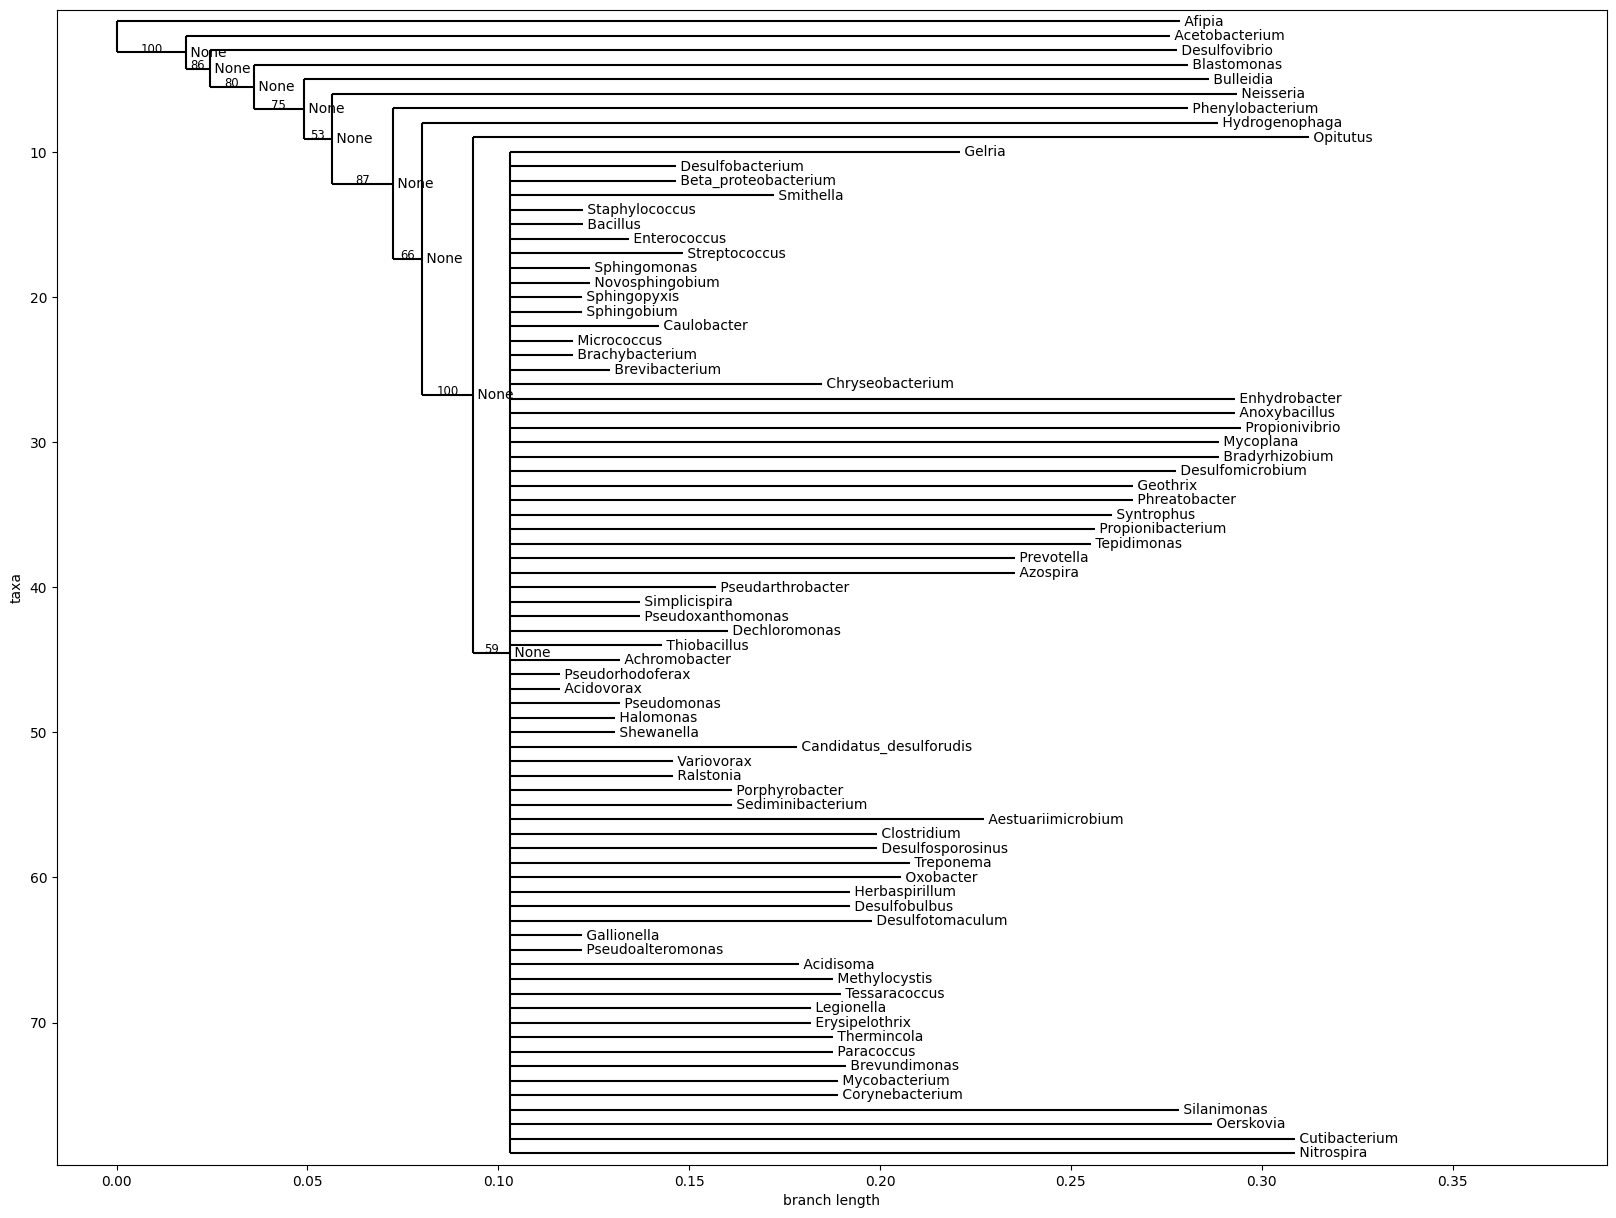

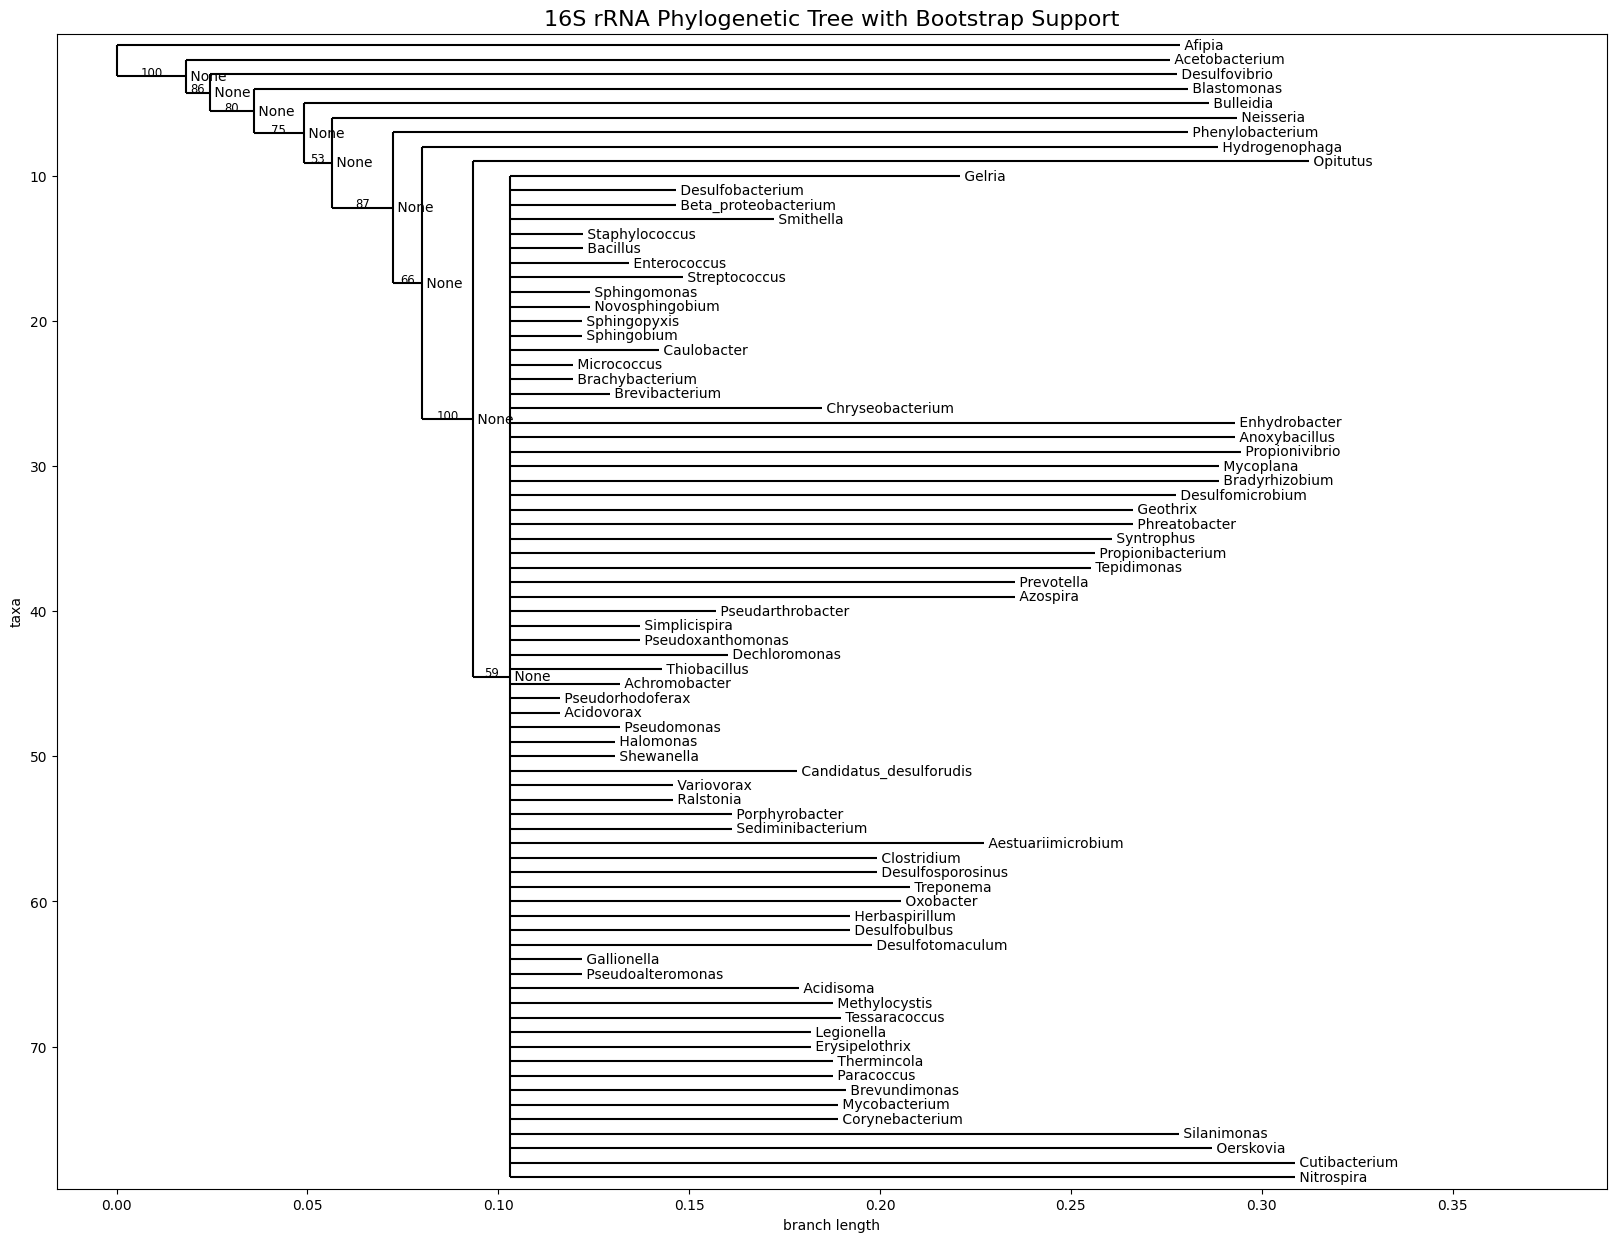

In [39]:
def plot_tree_with_annotations(consensus_tree, ax):
        
    # Draw tree with bootstrap values
    Phylo.draw(consensus_tree, 
               axes = ax, 
               show_confidence=True,
               label_func=lambda x: f"{x.name}" if x.confidence else x.name
    )

# Create the figure and axes outside the function
fig, ax = plt.subplots(figsize=(20, 15))

# Call the function, passing the external ax
plot_tree_with_annotations(consensus_tree, ax)

# Explicitly set the current axes to ensure the title is added to the correct subplot
plt.sca(ax)  # Set the current axes to `ax`
ax.set_title("16S rRNA Phylogenetic Tree with Bootstrap Support", fontsize=16)

# Display the plot
plt.show()

Note that there are two trees, that is because I didnt manage to put the title on the native Phylo tree and it was no possible to no draw the first one. The second one is more complete.

## 5.6. Summarising the Results

In [ ]:
def summarize_analysis(final_sequences, consensus_tree, output_dir):
    """Generate analysis summary"""
    summary = {
        'total_genera': len(final_sequences['Genus'].unique()),
        'sequences_retrieved': len(final_sequences),
        'avg_sequence_length': round(final_sequences['Sequence'].str.len().mean(), 4),
        'genera_list': ', '.join(final_sequences['Genus'].unique())
    }
    
    # Save summary
    with open(output_dir/'analysis_summary.txt', 'w') as f:
        for key, value in summary.items():
            f.write(f"{key}: {value}\n")
            
    return summary
Summary = summarize_analysis(final_sequences, consensus_tree, base_dir)
Summary

## 5.7. Analysing the Consensus Tree Results

High Confidence Clades: Several clades show very high bootstrap support (100%), particularly at deeper nodes in the tree. For example, the clade containing Clavibacter, Oerskovia and related genera has 100% support, indicating these groupings are highly reliable.
The relationship between Brevibacterium, Pseudarthrobacter and Brachybacterium is well-supported with bootstrap values of 81-83%.

Moderate Confidence Clades: Many clades show moderate support (60-80%). For example:
The clade containing Mycobacterium and Legionella (64-66% support). The grouping of Paracoccus and Neisseria (63-68% support). These moderate values suggest some uncertainty in these relationships, though they're still reasonably supported.

Taxonomic Implications: The tree shows clear separation between major bacterial groups. For example, Clostridium, Bulleidia, and Corynebacterium form an early-branching group.
Aquamicrobium and Novosphingobium cluster together (83% support), suggesting they share a more recent common ancestor.
The clustering of Methyloversatilis with Enterococcus and related genera suggests some interesting evolutionary relationships that might warrant further investigation.

Data Quality: The presence of many moderate to high bootstrap values (>60%) suggests generally good quality sequence data and alignment.
The tree shows a good mix of deep and shallow relationships, indicating the analysis captured both ancient and recent evolutionary events.
There are no extremely low bootstrap values (<50%), which supports the overall robustness of the analysis.

# 6 Consensus Trees/Newick iTOL visualisation 
## 6.1. Introduction
In this section we aim to visualize the consensus phylogenetic trees generated. The primary focus is to annotate these trees based on two key parameters:
Category: depending on the failure analysis category 1,2,3.
Abundance: The percentage of abundance of the genus on a sample, normalised to the sample.
By doing so, we seek to gain insights into the microbial community relationships and posterior metabolism pathways and its potential role in the system's failure.

### Objective
Identify the genus that are associated with the failure analyis on a positive or inverse way. For each of the phylogenetic trees here studied. 
### Methodology
We use the ETE Toolkit for the visualization, employing various annotations and styles to represent the category and abundance data. The tree is scaled and styled to facilitate easy interpretation.

## 6.2 Annotating the tree and importing it with ete3

Annotating the netweick tree with the information of the respective dataframe with category and abundance for the genera found on the distintic sites/samples.

In [35]:
current_columns = selected_taxa.columns.tolist()
new_columns = ['Jointax', 'Kingdom','Phylum', 'Class', 'Order', 'Family', 'Genus', 'GID']
combined_columns= new_columns + current_columns[8:]
selected_taxa.columns = combined_columns

In [36]:
from ete3 import Tree
t = Tree("data_tree/consensus_tree_integrate.newick", format=0)

In [70]:
selected_taxa["Source"].unique()

array([' ', 'chk-core', 'chk', 'chk-core-us', 'chk-us', 'core-us', 'core',
       'us'], dtype=object)

## 6.3 Color Scheme Management
Several trees are passed throught the whole notebook, so it is important to stablish the coloring system that allows the pipeline to automatically decide how to color code the tree.

In [47]:
def get_color_scheme(genus_name: str) -> str:
    """
    Color scheme for bacterial categories:
    - checked (chk): #000080 (navy blue)
    - usual (us): #8B0000 (dark red)
    - chk-us: #9370DB (purple)
    - chk-core: #000033 (darker navy)
    - core-us: #654321 (dark brown)
    - chk-core-us: #4A0404 (deep burgundy)
    """
    if 'Source' not in selected_taxa.columns:
        return 'black'
    
    try:
        genus_source = selected_taxa.loc[selected_taxa['Genus'] == genus_name, 'Source'].iloc[0]
        source = str(genus_source).lower()
        #chk-core', 'chk', 'chk-core-us', 'chk-us', 'core-us
        
        if 'chk-core-us' in source:
            return '#4A0404'  # Deep burgundy for all three
        elif 'chk-core' in source:
            return '#000033'  # Darker navy for checked+core
        elif 'core-us' in source:
            return '#654321'  # Dark brown for core+usual
        elif 'chk-us' in source:
            return '#9370DB'  # Purple for checked+usual
        elif 'chk' in source:
            return '#000080'  # Navy blue for checked only
        elif 'us' in source:
            return '#8B0000'  # Dark red for usual only
        return 'black'
        
    except (IndexError, KeyError):
        return 'black'
# Define set to track added names
added_names = set()

## 6.4. iTOL visualisation

In [38]:
# Load the tree 
t = Tree("data_tree/consensus_tree_integrate.newick", format=0)
# Define category colors with stronger values
category_colors = {
    'category_1': '#008800',  # Stronger green #66AA66
    'category_2': '#FF8C00',  # Stronger orange
    'category_3': '#FF0000'   # Pure red
}
# Initialize an empty dictionary to store the aggregated data
aggregated_data = {}

# Loop through each row in the DataFrame
for index, row in selected_taxa.iterrows():
    genus = row['Genus']  # Using level_6 for genus on checked and single df
    if genus not in aggregated_data:
        aggregated_data[genus] = {'category_1': 0, 'category_2': 0, 'category_3': 0}
    
    # Loop through each site column
    site_columns = [col for col in selected_taxa.columns if col.startswith('site_')]
    for site_column in site_columns:
        category = category_dict[site_column]
        abundance = row[site_column]
        
        if category == 1:
            aggregated_data[genus]['category_1'] += abundance
        elif category == 2:
            aggregated_data[genus]['category_2'] += abundance
        elif category == 3:
            aggregated_data[genus]['category_3'] += abundance
# Create tree style
ts = TreeStyle()
ts.show_leaf_name = False  # Change to False to avoid double names
ts.branch_vertical_margin = 5 # Space between the branches
ts.scale = 120 # longer horizontally
ts.show_branch_support = False  # Show bootstrap values

nstyle = NodeStyle()
nstyle["size"] = 5
nstyle["fgcolor"] = "#666666"  # Darker grey
nstyle["hz_line_width"] = 2  # Horizontal line thickness
nstyle["vt_line_width"] = 2  # Vertical line thickness
# Function to add bootstrap labels
def layout(node):
    if not node.is_leaf():
        # Add bootstrap value without filtering
        if hasattr(node, "support"):
            # Make sure we display the support value as percentage
            support_value = node.support *100 if node.support <=1 else node.support
            bootstrap_face = TextFace(f"{support_value:.0f}%", fsize=8, fgcolor="braun")
            node.add_face(bootstrap_face, column=0, position="branch-top")
ts.layout_fn = layout
# Apply style and add annotations
for node in t.traverse():
    if node.is_leaf() and node.name in aggregated_data:
        # Extract name and bootstrap value if present
        name_parts = node.name.split('(')
        clean_name = name_parts[0].strip()
        # To handle color depending on the dataframe of origin, pass the genus name
        node_color = get_color_scheme(clean_name)
               
        # Only add name if we haven't seen it before
        if clean_name not in added_names:
            name_face = TextFace(clean_name, fsize=10, fgcolor=node_color)
            node.add_face(name_face, column=1, position="branch-right")
            added_names.add(clean_name)

            #for branch coloring
            node.img_style["fgcolor"] = node_color
           
            # Add bootstrap value if present
            if len(name_parts) > 1:
                bootstrap = name_parts[1].rstrip(')')
                bootstrap_face = TextFace(f"({bootstrap})", fsize=8)
                node.add_face(bootstrap_face, column=1, position="branch-top")
        
            # Add abundance indicators
            column = 2  # Start circles after name and bootstrap
            for category, abundance in aggregated_data[clean_name].items():
                if abundance > 0:
                    circle = CircleFace(radius= 3 + (abundance/5),
                                    color=category_colors[category],
                                    style="sphere")
                    node.add_face(circle, column=column, position="branch-right")
                    column += 1
# Add category legend 
legend_faces = []
categories = {
    'category_1': 'Normal Operation',
    'category_2': 'Early Warning',
    'category_3': 'System Failure'
}
for cat_num, desc in categories.items():
    legend_face = CircleFace(5, category_colors[f'category_{cat_num[-1]}'])
    # Include both category number and description
    legend_faces.append(TextFace(f"  {cat_num} - {desc}", fsize=8))
    legend_faces.append(legend_face)
    legend_faces.append(TextFace("   "))  # Spacing
ts.legend_position = 3  
ts.legend.add_face(TextFace("System Categories", fsize=10, bold=True), column=0)
for idx, face in enumerate(legend_faces):
    ts.legend.add_face(face, column=idx % 3)         

t.render("data_tree/iTOL_visualisation.png", w=1100, h= 2550, dpi=300, tree_style=ts)

QStandardPaths: wrong permissions on runtime directory /run/user/1000/, 0755 instead of 0700


{'nodes': [[59.03581577662292,
   39.35957876888096,
   66.30176233374574,
   43.35090836587639,
   0,
   None],
  [125.2227761547661,
   9.978323992488598,
   132.48872271188893,
   13.969653589484036,
   1,
   None],
  [122.6128481514476,
   68.74083354527332,
   129.8787947085704,
   72.73216314226875,
   2,
   None],
  [184.22662176653768,
   31.93063677596351,
   191.4925683236605,
   35.92196637295895,
   3,
   None],
  [173.47447405130734,
   105.55103031458312,
   180.74042060843016,
   109.54235991157856,
   4,
   None],
  [234.14440120862716,
   68.11700910096009,
   241.41034776574998,
   72.10833869795553,
   5,
   None],
  [224.33609995116709,
   142.98505152820613,
   231.6020465082899,
   146.97638112520156,
   6,
   None],
  [283.1641096562563,
   104.30338142595667,
   290.43005621337915,
   108.29471102295211,
   7,
   None],
  [275.1977258510268,
   181.66672163045556,
   282.46367240814965,
   185.658051227451,
   8,
   None],
  [332.33204341365064,
   126.255694209

## 6.5. Results Analysis

### Phylogenetic Tree for usual_taxa
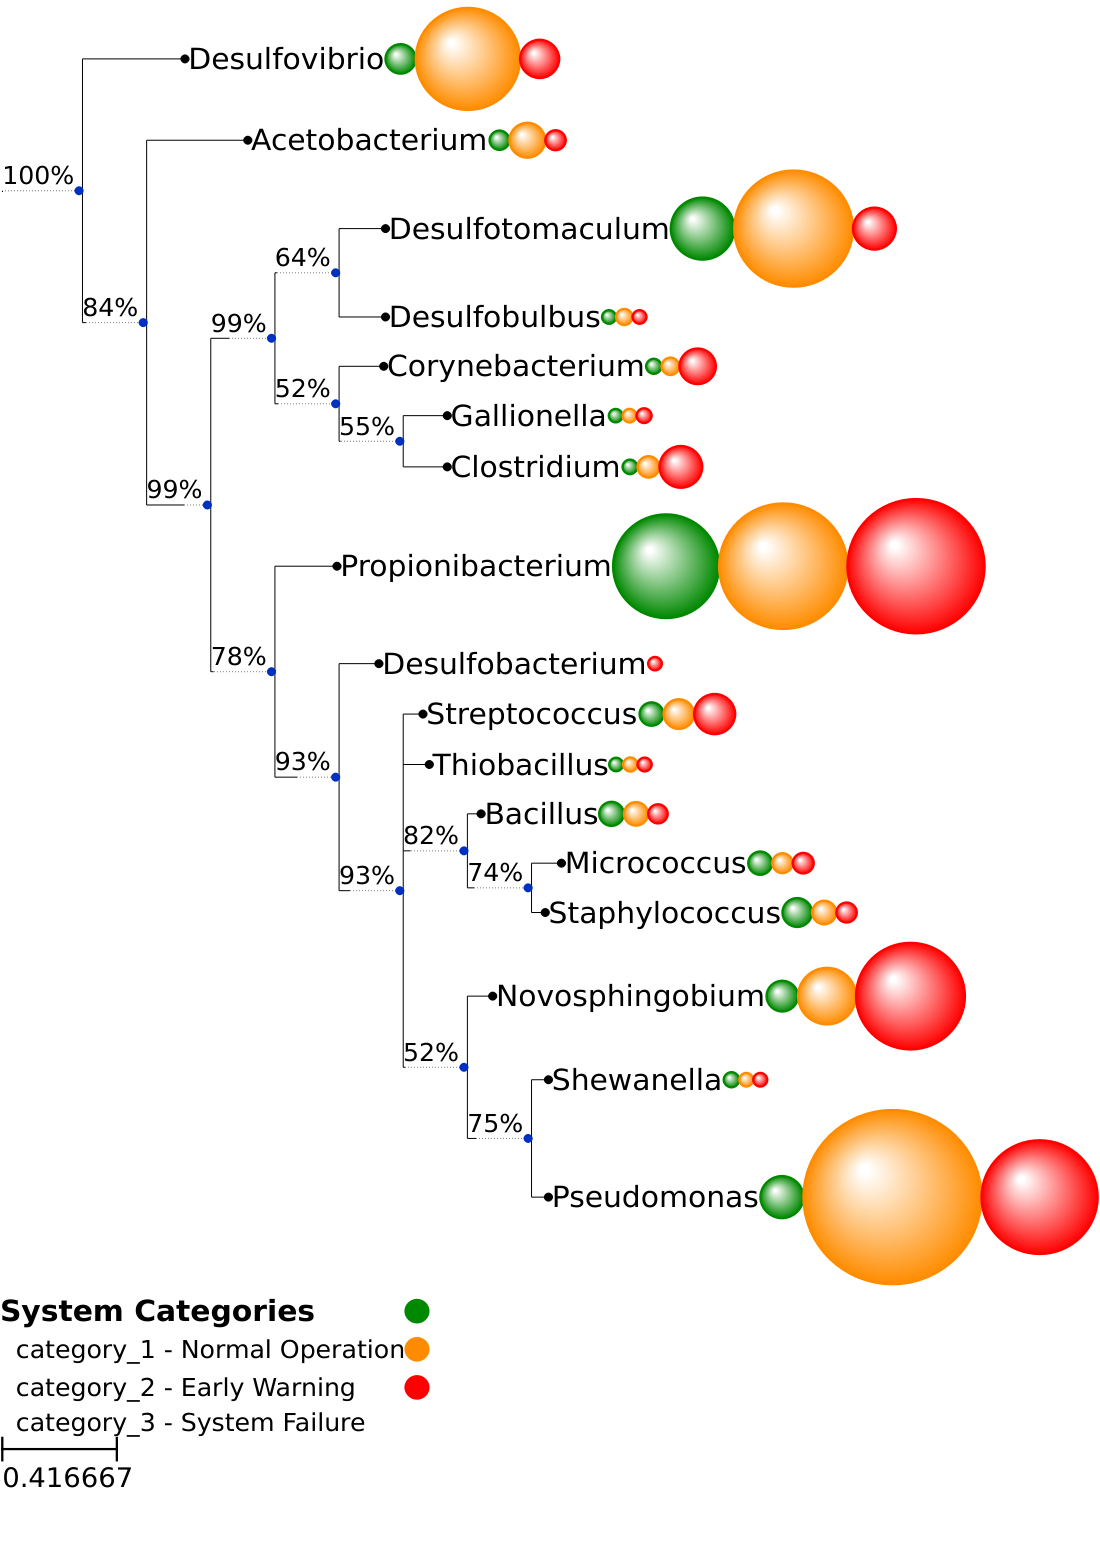 
### Phylogenetic Tree of checked_taxa

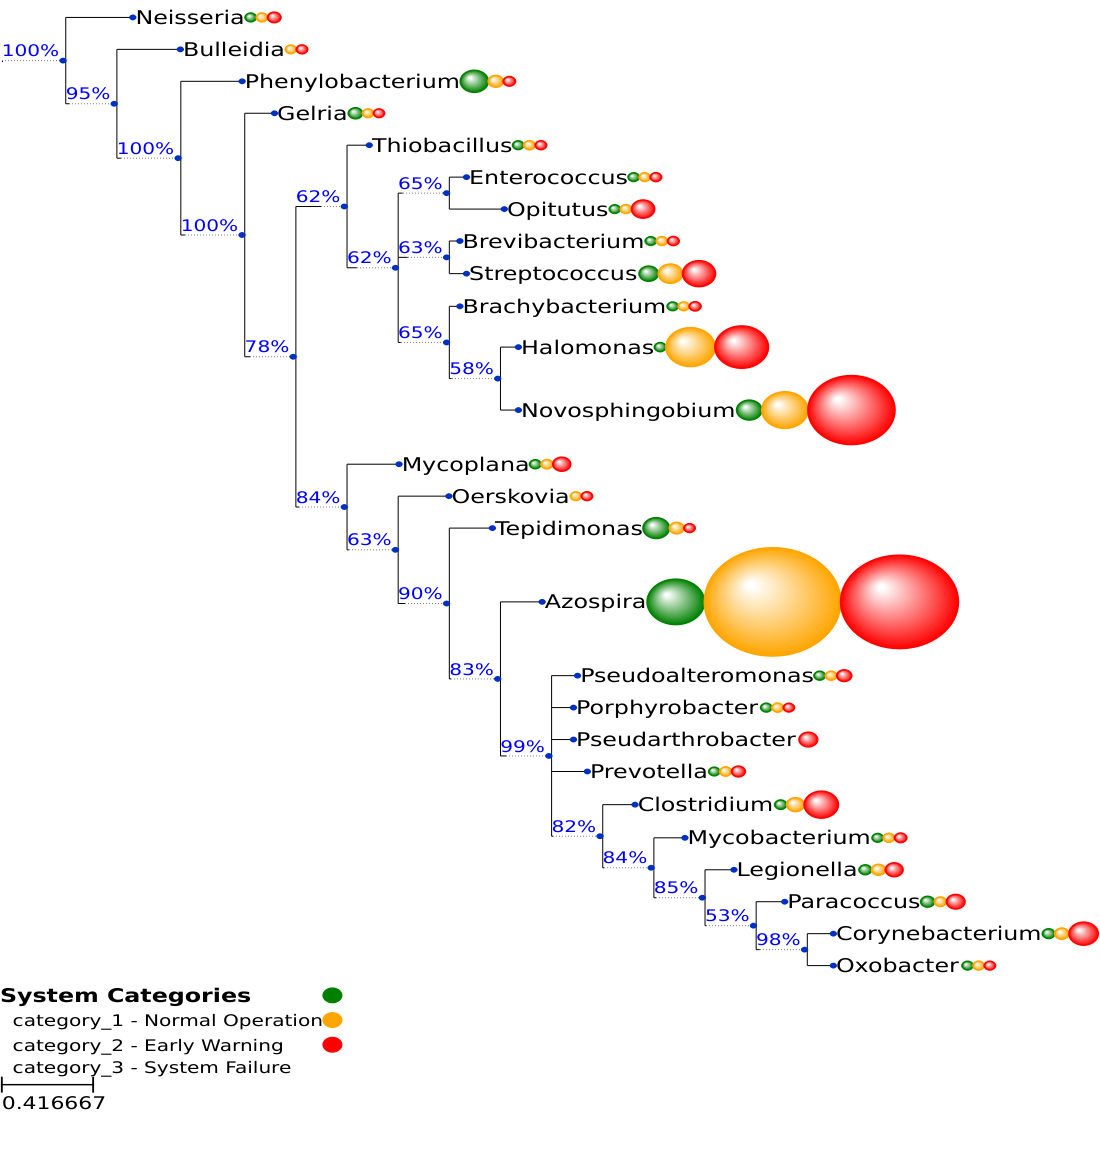

#### Phylogenetic Tree for core_taxa

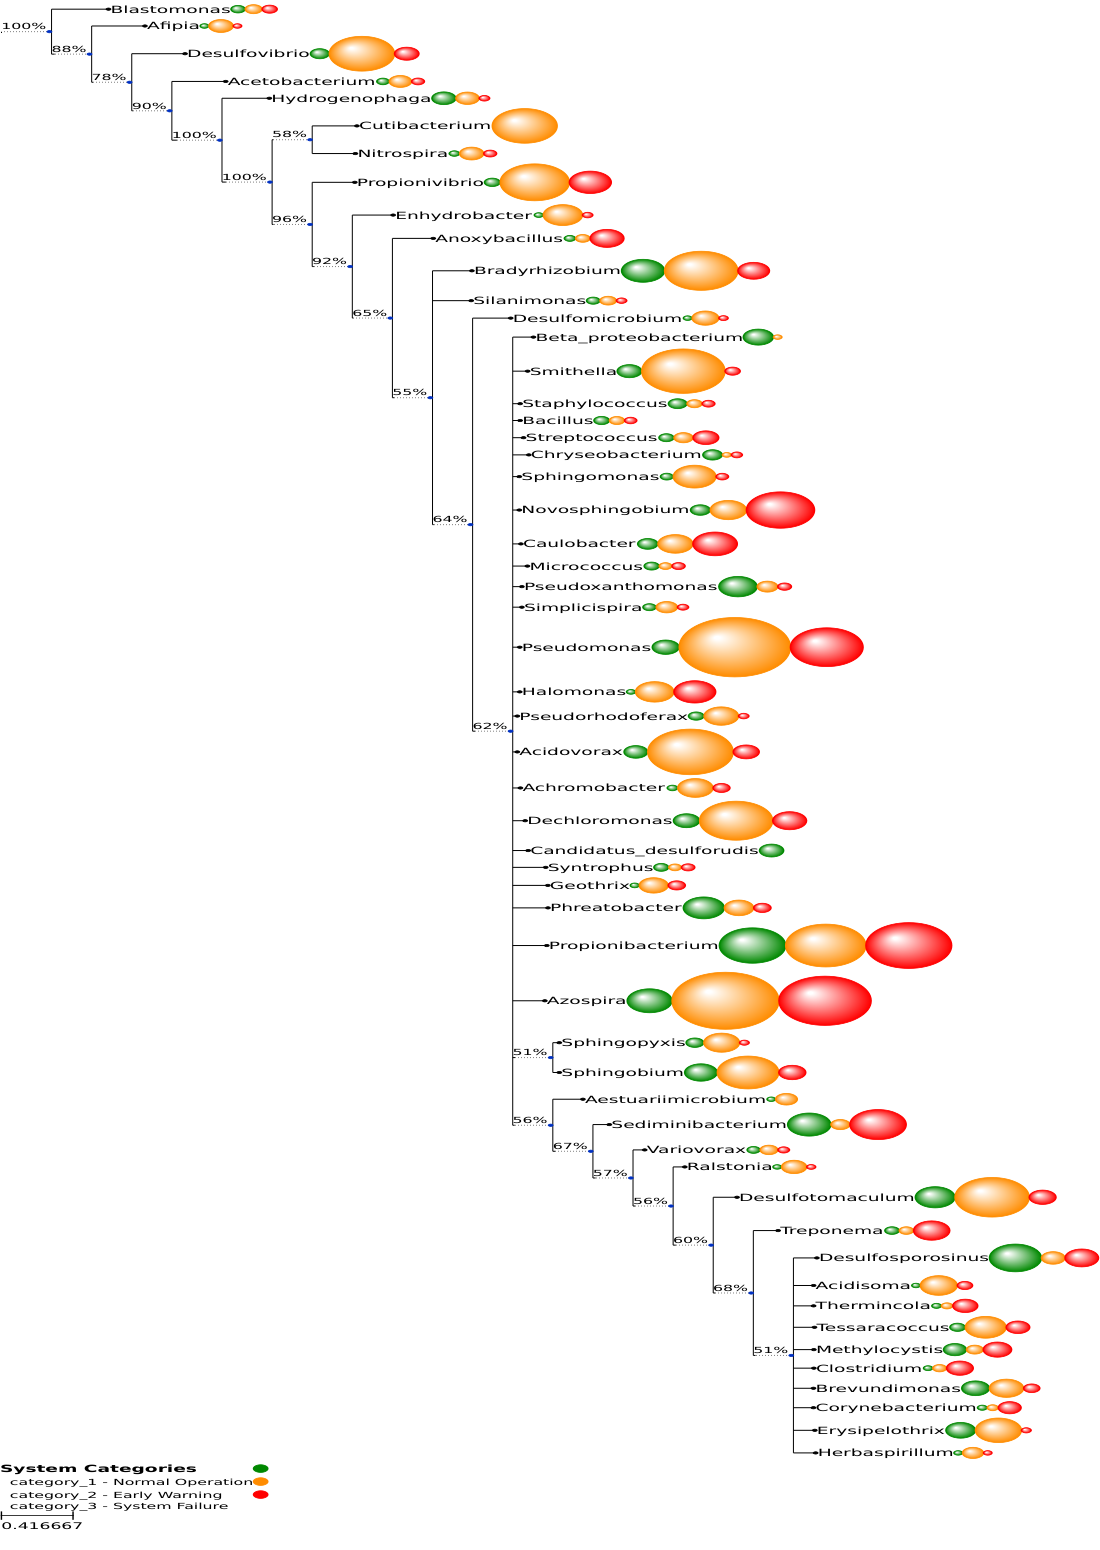

### Phylogenetic Tree for check_core_usual_taxa only 50
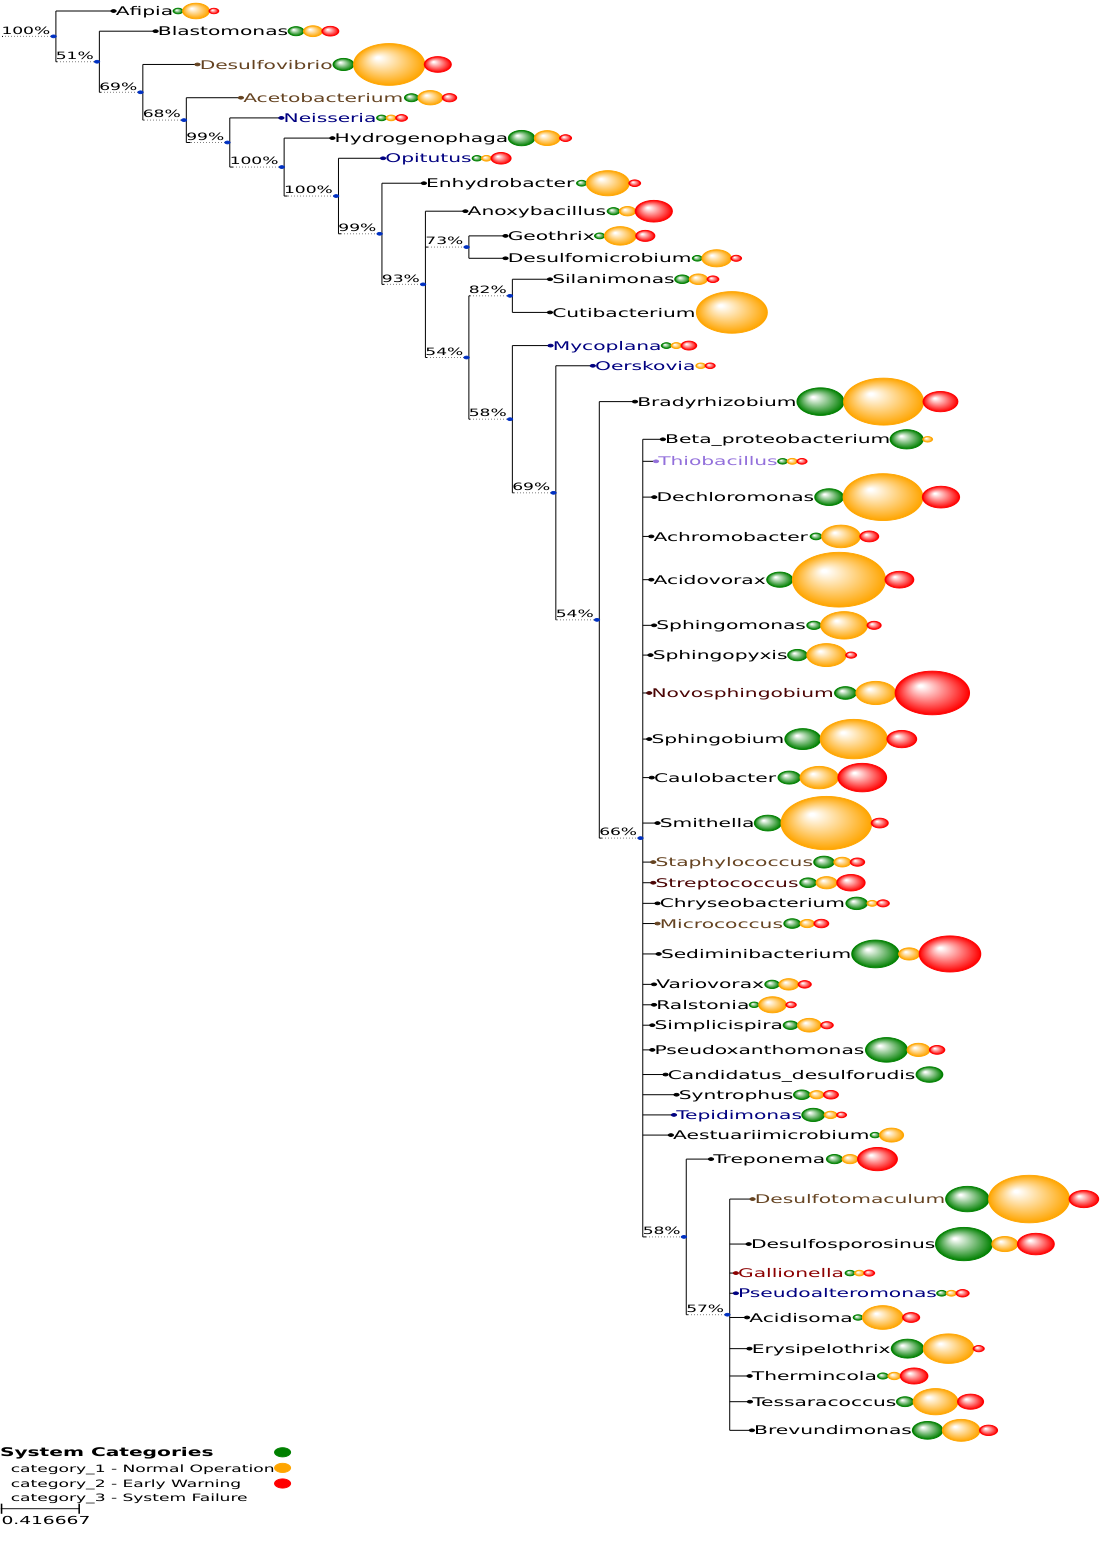

I'll help you summarize the key findings from your phylogenetic analysis to prepare for the PICRUSt functional analysis. Here's a concise discussion that captures the main points:

### Summary of Phylogenetic Analysis for PICRUSt Preparation

The phylogenetic analysis revealed several key patterns that will be important for functional prediction using PICRUSt:

1. **Evolutionary Groups**
- Strong clustering between traditional corrosion-associated bacteria (e.g., Desulfovibrio) and newly identified genera
- High bootstrap support (>80%) for deep branches, indicating reliable evolutionary relationships
- Clear metabolic evolution pattern from anaerobic to aerobic organisms

2. **Functional Patterns**
- Sulfate-reducing bacteria (like Desulfovibrio) show pioneer species behavior, declining in category 3 environments
- Biofilm-forming bacteria (Streptococcus, Corynebacterium, Clostridium) cluster together
- Novel protective associations discovered (e.g., Phenylobacterium, Hydrogenophaga) potentially due to aromatic compound metabolism

3. **Community Succession**
- Clear ecological succession from early colonizers to late-stage communities
- Some genera maintain presence across categories but with shifting abundances
- Temperature-tolerant and halotolerant bacteria form distinct clusters

4. **Key Findings for PICRUSt**
- Mixed clades of known and novel corrosion-associated bacteria suggest shared metabolic capabilities
- Environmental adaptation groups indicate potential metabolic shifts during system degradation
- Strong bootstrap support for novel clades validates their inclusion in functional analysis

This phylogenetic foundation suggests that PICRUSt analysis should focus on:
- Metabolic pathways shared between traditional and newly identified corrosion-associated bacteria
- Functional transitions between succession stages
- Protective metabolic capabilities in inverse-relationship genera

In [ ]:
from ete3 import Tree, TextFace

# Load the tree
t = Tree("data/consensus_tree.newick", format=0) 

# Metabolic data 
metabolic_data = {
          'Clostridium': 'Pathway_Z',
      'Corynebacterium': 'Pathway_A',
               'Gelria': 'Pathway_B',
          'Haemophilus': 'Pathway_C',
            'Halomonas': 'Pathway_D',
           'Legionella': 'Pathway_E',
            'Oerskovia': 'Pathway_F',
            'Oxobacter': 'Pathway_G',
        'Porphyromonas': 'Pathway_H',
              'Psb-m-3': 'Pathway_I',
    'Pseudarthrobacter': 'Pathway_J',
    'Pseudoalteromonas': 'Pathway_K',
          'Rhodobacter': 'Pathway_L',
           'Roseateles': 'Pathway_M',
            'Roseococc': 'Pathway_N'
}

# Annotate the tree
for leaf in t.iter_leaves():
    if leaf.name in metabolic_data:
        metabolic_info = TextFace(metabolic_data[leaf.name])
        leaf.add_face(metabolic_info, column=1, position="branch-right")

# Show or render the tree
t.show()
# Render the tree
#t.render("%%inline", w=800, units="px", tree_style=ts)

## 6.6. Missing Bacteria
Different searchs have been unsuscessfull retrieving the total of the bacteria sequences, with a failing percentage of 50-95%. In the last search there were some missing bacteria, therefore the idea is to append them to the accension_taxa dataframe so that we can plot the missings ones.

In [59]:
# 1. First load the dataframes and verify they loaded correctly
all_taxa = pd.read_excel('~/MIC/2_Micro/data_Ref/merged_to_sequence.xlsx',
                        sheet_name='core_check_usual_taxa',
                        header=[0,1,2,3,4,5,6,7])
print("all_taxa loaded:", type(all_taxa))

accession = pd.read_csv('data_tree/taxa_accension.csv')
print("accession loaded:", type(accession))

# 2. Check the structure of each dataframe
print("\nall_taxa columns:")
print(all_taxa.columns.get_level_values(6))

print("\naccession columns:")
print(accession.columns.tolist())

# 3. Now try the comparison
all_taxa_g = set(all_taxa.columns.get_level_values(6))
accession_g = set(accession['Genus'])  # Make sure 'Genus' is actually a column name
missing_genera = all_taxa_g - accession_g

print("\nMissing genera:")
for genus in sorted(missing_genera):
    print(f"- {genus}")

all_taxa loaded: <class 'pandas.core.frame.DataFrame'>
accession loaded: <class 'pandas.core.frame.DataFrame'>

all_taxa columns:
Index(['Unnamed: 0_level_6', 'Unnamed: 1_level_6', 'Unnamed: 2_level_6',
       'Azospira', 'Brachybacterium', 'Brevibacterium', 'Bulleidia',
       'Clostridium', 'Corynebacterium', 'Enterococcus', 'Gelria', 'Halomonas',
       'Legionella', 'Mycobacterium', 'Mycoplana', 'Neisseria',
       'Novosphingobium', 'Oerskovia', 'Opitutus', 'Oxobacter', 'Paracoccus',
       'Phenylobacterium', 'Porphyrobacter', 'Prevotella', 'Psb-m-3',
       'Pseudarthrobacter', 'Pseudoalteromonas', 'Streptococcus',
       'Tepidimonas', 'Thiobacillus', 'Acetobacterium', 'Achromobacter',
       'Acidisoma', 'Acidovorax', 'Aestuariimicrobium', 'Afipia',
       'Anoxybacillus', 'Bacillus', 'Beta_proteobacterium', 'Blastomonas',
       'Bradyrhizobium', 'Brevundimonas', 'Candidatus_desulforudis',
       'Caulobacter', 'Chryseobacterium', 'Clostridium_sensu_stricto_12',
       'Cutib

Missing genera:
- Clostridium_sensu_stricto_12
- Oxalobacteraceae_unclassified
- Psb-m-3
- Ruminiclostridium_1
- Unnamed: 0_level_6
- Unnamed: 1_level_6
- Unnamed: 2_level_6
- Wchb1-05

In [40]:
# Comunicating with the NCBI
from config import NCBI_API_KEY, NCBI_EMAIL

Entrez.email= "wattsbeatrizamanda@gmail.com" #
Entrez.api_key  = "01d2f369faef0e78cd4906063672fab7c809"


logging.basicConfig(
    level=logging.INFO,
    format='%(asctime)s - %(levelname)s - %(message)s'
)


In [41]:
def search_sequences(genus, entrez, max_retries=5, base_delay=30, max_delay=120):
    """
    Search for sequences with improved error handling and validation.
    """
    if not isinstance(genus, str) or not genus.strip():
        raise ValueError("Genus must be a non-empty string")
    if not hasattr(entrez, 'email') or not entrez.email:
        raise RuntimeError("Entrez email configuration missing")
    
    retry_count = 0
    delay = base_delay

    while retry_count < max_retries:
        try:
            search_term = (f"{genus}[Organism] AND "
                         "(16S[All Fields] OR 16S ribosomal RNA[All Fields] OR "
                         "16S rRNA[All Fields]) AND "
                         "500:2000[Sequence Length]")
            
            logging.info(f"Attempting search for {genus} (attempt {retry_count + 1}/{max_retries})")
            # Search NCBI database
            handle = entrez.esearch(db="nucleotide", term=search_term, retmax=100)
            
            try:
                record = entrez.read(handle)
                time.sleep(5)
            except entrez.Parser.ValidationError as ve:
                logging.error(f"NCBI validation error for {genus}: {str(ve)}")
                retry_count += 1
                continue
            finally:
                handle.close()
            
            sequence_count = len(record.get('IdList', []))
            logging.info(f"Found {sequence_count} sequences for {genus}")
            
            if sequence_count > 0:
                return record['IdList']
            
            logging.warning(f"No sequences found for {genus}")
            return []
            
        except Exception as e:
            logging.error(f"Error in search for {genus}: {str(e)}")
            
        retry_count += 1
        if retry_count < max_retries:
            wait_time = min(delay * (2 ** retry_count), max_delay)
            logging.info(f"Waiting {wait_time} seconds before retry...")
            time.sleep(wait_time)
    
    return []

In [42]:
def append_missing_genera():
    
    # Read existing results
    existing_df = pd.read_csv('data_tree/taxa_accension.csv')
    
    # Search only for missing bacteria
    additional_results = {}
    for bacteria in missing_genera:
        print(f"Searching for {bacteria}...")
        result = search_sequences(bacteria, Entrez)
        if result:
            additional_results[bacteria] = result
            print(f"Found sequences for {bacteria}")
        else:
            print(f"No sequences found for {bacteria}")
        time.sleep(30)  # Being nice to NCBI
            
    # Create DataFrame for new sequences
    new_sequences = pd.DataFrame(list(additional_results.items()), 
                               columns=['Genus', 'IDs'])
    
    # Save new sequences separately
    new_sequences.to_csv('data_tree/additional_sequences.csv')
    
    # Combine for further processing
    combined_df = pd.concat([existing_df, new_sequences], ignore_index=True)
    combined_df.to_csv('data_tree/combined_taxa_accension.csv')
    
    return combined_df

In [45]:
# Search just the missing genera
missing_genera = [
    "Clostridium_sensu_stricto_12",
    "Oxalobacteraceae_unclassified",
    "Psb-m-3", 
    "Ruminiclostridium", #_1
    "Wchb1-05"
]
results_missing = {}
for bacteria in missing_genera:
    print(f"Searching for {bacteria}...")
    result = search_sequences(bacteria, Entrez)  # Keep this as result
    if result:
        results_missing[bacteria] = result    # Store in results_missing
        print(f"Found sequences for {bacteria}")
    time.sleep(30)  # Being nice to NCBI

Searching for Clostridium_sensu_stricto_12...


2025-01-17 11:14:54,128 - INFO - Attempting search for Clostridium_sensu_stricto_12 (attempt 1/5)
2025-01-17 11:15:09,781 - INFO - Found 0 sequences for Clostridium_sensu_stricto_12
2025-01-17 11:15:09,791 - WARNING - No sequences found for Clostridium_sensu_stricto_12
2025-01-17 11:15:41,703 - INFO - Attempting search for Oxalobacteraceae_unclassified (attempt 1/5)


Searching for Oxalobacteraceae_unclassified...


2025-01-17 11:15:49,164 - INFO - Found 0 sequences for Oxalobacteraceae_unclassified
2025-01-17 11:15:49,171 - WARNING - No sequences found for Oxalobacteraceae_unclassified
2025-01-17 11:16:20,423 - INFO - Attempting search for Psb-m-3 (attempt 1/5)


Searching for Psb-m-3...


2025-01-17 11:16:26,375 - INFO - Found 0 sequences for Psb-m-3
2025-01-17 11:16:26,384 - WARNING - No sequences found for Psb-m-3
2025-01-17 11:16:57,630 - INFO - Attempting search for Ruminiclostridium (attempt 1/5)


Searching for Ruminiclostridium...


2025-01-17 11:17:05,226 - INFO - Found 100 sequences for Ruminiclostridium


Found sequences for Ruminiclostridium


2025-01-17 11:17:36,690 - INFO - Attempting search for Wchb1-05 (attempt 1/5)


Searching for Wchb1-05...


2025-01-17 11:17:42,527 - INFO - Found 0 sequences for Wchb1-05
2025-01-17 11:17:42,533 - WARNING - No sequences found for Wchb1-05


In [44]:
# Create DataFrame for new sequences
new_sequences = pd.DataFrame(list(results_missing.items()), columns=['Genus', 'IDs'])

# Read your existing file
existing_df = pd.read_csv('data_tree/taxa_accension.csv')

# Combine old and new
combined_df = pd.concat([existing_df, new_sequences], ignore_index=True)

# Save with new name to be safe
combined_df.to_csv('data_tree/taxa_accension_complete.csv', index=False)

NameError: name 'results' is not defined